# Query and explore data included in WALIS

This notebook contains scripts that allow querying and extracting data from the "World Atlas of Last Interglacial Shorelines" (WALIS) database. The notebook calls scripts contained in the /scripts folder. After downloading the database (internet connection required), field headers are renamed, and field values are substituted, following 1:n or n:n relationships. The tables composing the database are then saved in CSV, XLSS (multi-sheet), and geoJSON formats. The notebook also contains some plotting functions.

## Dependencies and packages
This notebook calls various scripts that are included in the \scripts folder. The following is a list of the python libraries needed to run this notebook.

In [1]:
#Main packages
import pandas as pd
import pandas.io.sql as psql
import geopandas
import pygeos
import numpy as np
import mysql.connector
from datetime import date
import xlsxwriter as writer
import math
from scipy import optimize
from scipy import stats

#Plots
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Jupyter data display
import tqdm
from tqdm.notebook import tqdm_notebook
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

#Geographic 
from shapely.geometry import Point
from shapely.geometry import box
import cartopy as ccrs
import cartopy.feature as cfeature

#System
import os
import glob
import shutil

#pandas options for debugging
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Set a date string for exported file names
date=date.today()
dt_string = date.strftime("_%d_%m_%Y")

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

## Import database
Connect to the online MySQL database containing WALIS data and download data into a series of pandas data frames.

In [2]:
## Connect to the WALIS database server
%run -i scripts/connection.py

## Import data tables and show progress bar
with tqdm_notebook(total=len(SQLtables),desc='Importing tables from WALIS') as pbar:
 for i in range(len(SQLtables)): 
   query = "SELECT * FROM {}".format(SQLtables[i])
   walis_dict[i] = psql.read_sql(query, con=db)
   query2 = "SHOW FULL COLUMNS FROM {}".format(SQLtables[i])
   walis_cols[i] = psql.read_sql(query2, con=db) 
   pbar.update(1)

%run -i scripts/create_outfolder.py

Importing tables from WALIS:   0%|          | 0/19 [00:00<?, ?it/s]

## Query the database
Now, the data is ready to be queried according to a user input. There are two ways to extact data of interest from WALIS. Run either one and proceed.

1. [Select by author](#Query-option-1---Select-by-author)
2. [Select by geographic coordinates](#Query-option-2---Select-by-geographic-extent)

### Query option 1 - Select by author

This option compiles data from multiple users who collaborated to create regional datasets for the WALIS Special Issue in ESSD. Select "WALIS Admin" in the dropdown menu if you want to extract the entire database.

**NOTE: If you want to change users, just re-run this cell and select a different set of values**

In [3]:
%run -i scripts/select_user.py
multiUsr

SelectMultiple(options=('Alessandro Fontana', 'Alessio Rovere', 'Alexander Simms', 'Alexandra Villa', 'Andrew …

Once the selection is done, run the following cell to query the database and extract only the data inserted by the selected user(s)

In [4]:
%run -i scripts/multi_author_query.py

Extracting values for: WALIS Admin

The database you are exporting contains:
3999 RSL datapoints from stratigraphy
463 RSL datapoints from single corals
76 RSL datapoints from single speleothems
30 RSL indicators
19 Elevation measurement techniques
11 Geographic positioning techniques
28 Sea level datums
2717 U-Series ages (including RSL datapoints from corals and speleothems)
583 Amino Acid Racemization samples
213 Electron Spin Resonance ages
597 Luminescence ages
120 Chronostratigraphic constraints
160 Other age constraints
2107 References


### Query option 2 - Select by geographic extent
This option allows the download of data by geographic extent, defined as maximum-minimum bounds on Latitude and Longitude. Use this website to quickly find bounding coordinates: http://bboxfinder.com.

In [8]:
# bounding box coordinates in decimal degrees (x=Lon, y=Lat)
xmin=2.103882
xmax=3.630981
ymin=39.219487
ymax=39.993956

#2.103882,39.219487,3.630981,39.993956

In [9]:
# From the dictionary in connection.py, extract the dataframes
%run -i scripts/geoextent_query.py

Extracting values for the coordinates you specified
The database you are exporting contains:
11 RSL datapoints from stratigraphy
0 RSL datapoints from single corals
60 RSL datapoints from single speleothems
4 RSL indicators
4 Elevation measurement techniques
1 Geographic positioning techniques
3 Sea level datums
72 U-Series ages
8 Amino Acid Racemization samples
0 Electron Spin Resonance ages
0 Luminescence ages
1 Chronostratigraphic constraints
0 Other age constraints
22 References


## Substitute data codes 
The following code makes joins between the data, substituting numerical or comma-separated codes with the corresponding text values.

**WARNING - MODIFICATIONS TO THE ORIGINAL DATA**

<u>The following adjustments to the data are made:</u>
1. If there is an age in ka, but the uncertainty field is empty, the age uncertainty is set to 30%
2. If the "timing constraint" is missing, the "MIS limit" is taken. If still empty, it is set to "Equal to"

In [5]:
%run -i scripts/substitutions.py
%run -i scripts/make_summary.py

We are substituting values in your dataframes....
querying by user
Putting nice names to the database columns....
Done!!
making summary table....
Done!


## Write output
The following scripts save the data in Xlsx, CSV, and geoJSON format (for use in GIS software).

In [6]:
%run -i scripts/write_spreadsheets.py
%run -i scripts/write_geojson.py
print ('Done!')

Your file will be created in /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/WALIS/WALIS/Output/Data/ 
Done!


## Explore queried data through graphs
The following scrips produce a series of images representing different aspects of the data included in the database. Each graph is saved in the "Output/Images" folder in svg format.

The following graphs can be plotted:
1. [Monthly data insertion/update](#Monthly-data-insertion/update)
2. [References by year of publication](#References-by-year-of-publication)
3. [Elevation errors](#Elevation-errors)
4. [Sea level index points](#Sea-level-index-points)
5. [Elevation and positioning histograms](#Elevation-and-positioning-histograms)
6. [Quality plots](#Quality-plots)
7. [Maps](#Maps)
8. [Radiometric ages distribution](#Radiometric-ages-distribution)

### Monthly data insertion/update
This graph explores the timeline of data insertion or update in WALIS since its inception. Peaks in this graph correspond to data updated in bulk by the admin. 

<Figure size 432x288 with 0 Axes>

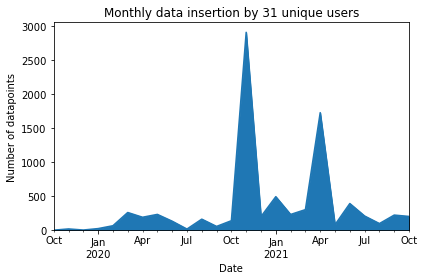

In [7]:
%run -i scripts/Database_contributions.py

### References by year of publication
This graph shows the year of publication of the manuscripts included in the WALIS "References" table. Note that these might not all be used in further data compilations.

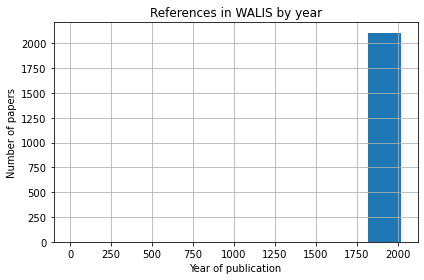

In [8]:
%run -i scripts/References_hist.py

### Elevation errors
These two graphs show the measured elevation errors (plotted as Kernel Density Estimate) reported for sea-level data within WALIS. These include "RSL from statigraphy" data points and single coral or speleothems indicating former RSL positions. The difference in the two plots resides in the treatment of outliers. Points having elevation uncertainties higher than 3.5 times the median absolute deviation are excluded from the graph in the left. All points are considered on the graph on the right side.

The outlier exclusion is bases on this reference:
>Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.

And was derived from this link: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting

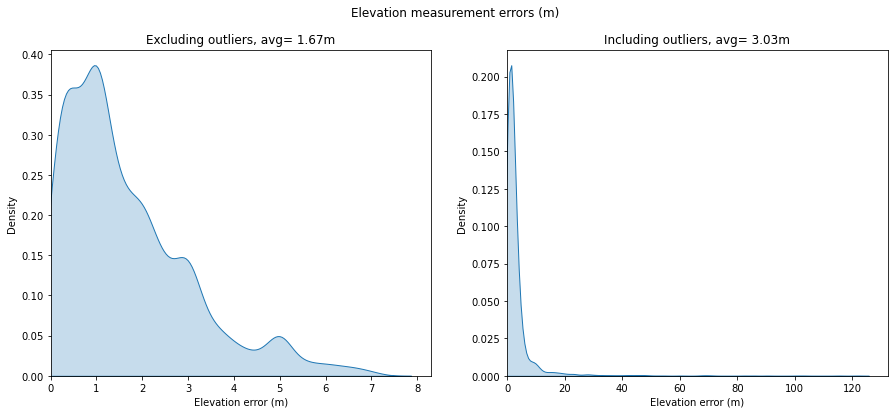

In [9]:
%run -i scripts/Elevation_error.py

### Sea level index points 
This graph shows the frequency of sea-level indicator types within the query.

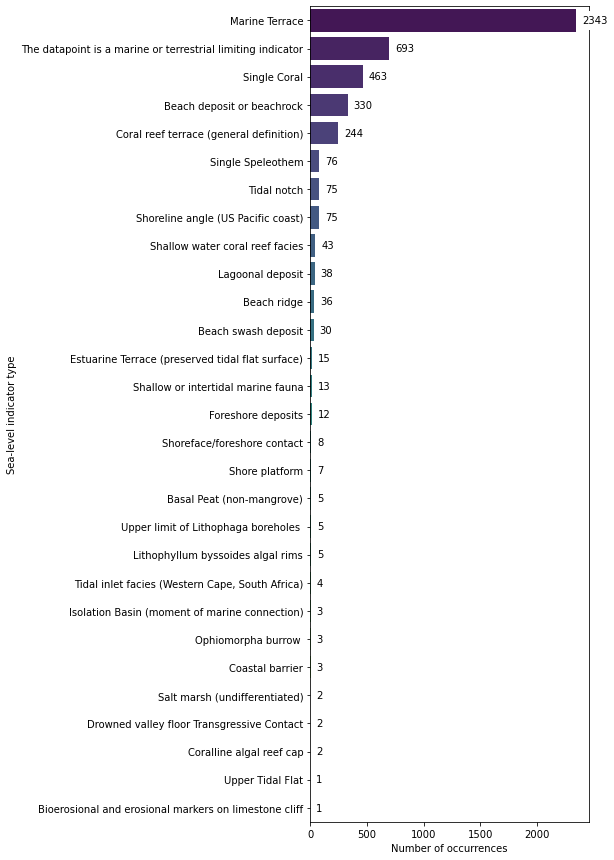

In [10]:
%run -i scripts/SL_Ind_Hist.py

### Elevation and positioning histograms
These graphs show the distributions of the elevation metadata (Elevation measurement technique and sea-level datum) used to describe sea-level datapoints in WALIS.

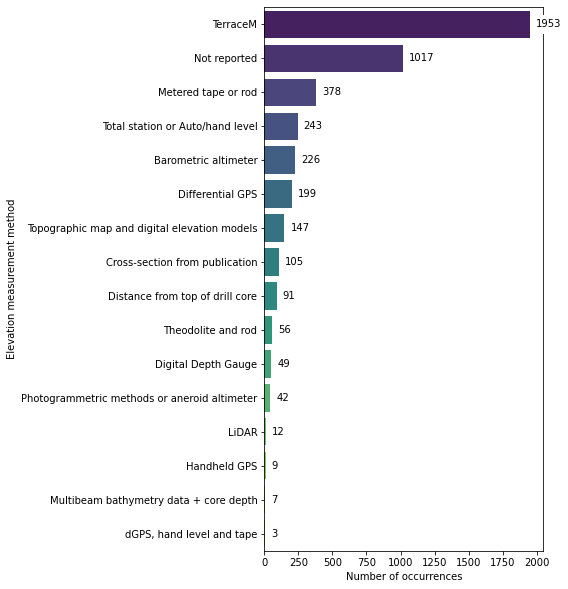

In [11]:
%run -i scripts/Vrt_meas_hist.py

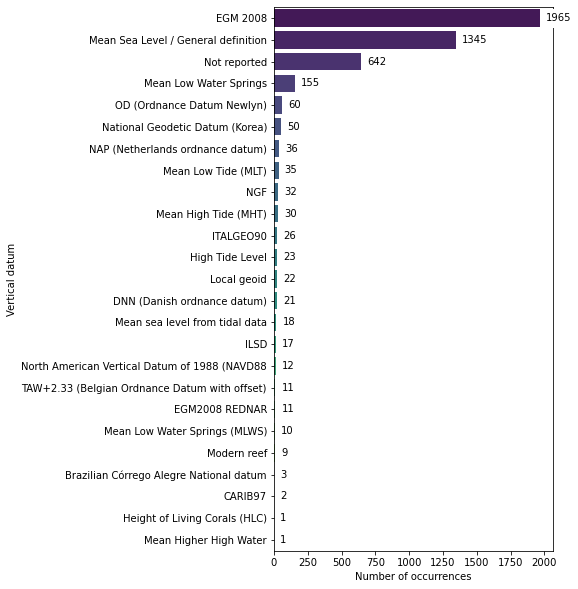

In [12]:
%run -i scripts/SL_datum_hist.py

### Quality plots
The RSL datapoints from stratigraphy contain two "data quality" fields, one for age and one for RSL information. Database compilers scored each site following standard guidelines (as per database documentation). This plot shows these quality scores plotted against each other. As the quality scores of one area can be better appreciated by comparison with other areas, tools to compare two nations or two regions are given.

#### Overall quality of selected area

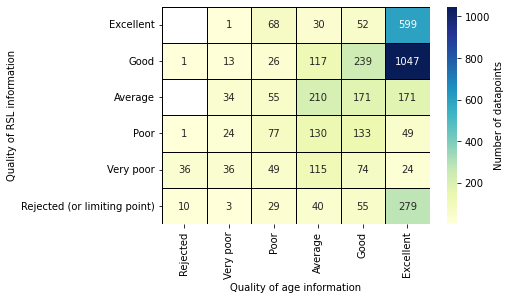

In [13]:
%run -i scripts/Quality_plot.py

#### Compare two nations

In [14]:
%run -i scripts/select_nation_quality.py
box

Box(children=(Dropdown(description='1st Nation:', options=('Albania', 'Algeria', 'Angola', 'Argentina', 'Austr…

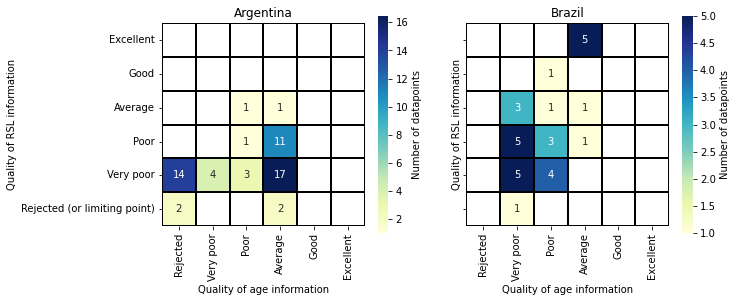

In [15]:
%run -i scripts/Quality_nations.py

#### Compare two regions

In [16]:
%run -i scripts/select_region_quality.py
box

Box(children=(Dropdown(description='1st Region:', options=('Lezhe', 'Alger', 'Tipaza', 'Benguela', 'Namibe', '…

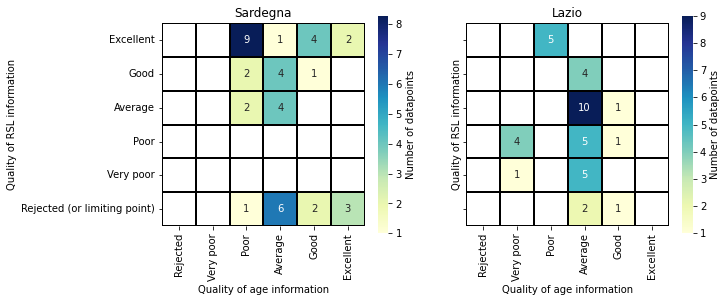

In [17]:
%run -i scripts/Quality_regions.py

## Maps
In this section, the data is organized in a series of maps. Some styling choices are available.

In [18]:
%run -i scripts/select_map_options.py

Select(description='Style', options=('Highlight', 'Single points'), rows=1, value='Highlight')

RadioButtons(description='Global map?', layout=Layout(width='max-content'), options=('yes', 'no'), value='yes'…

Dropdown(description='Map choice', options=('RSL datapoints', 'U-series (corals)', 'U-series (oolites)', 'U-se…

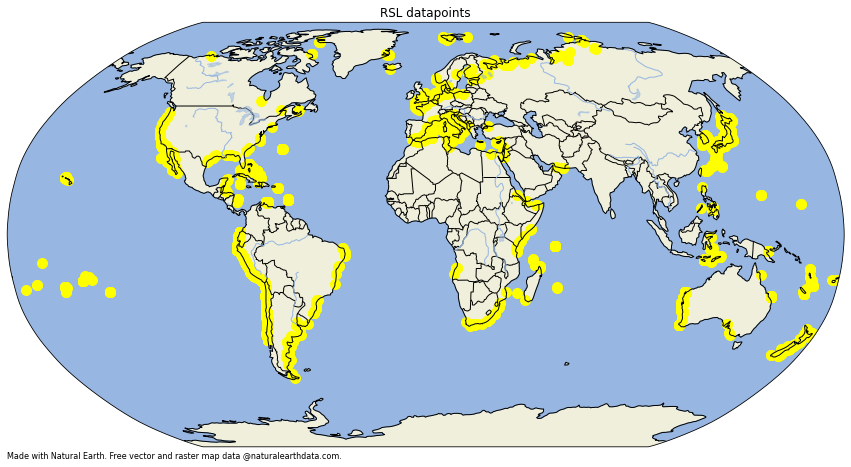

In [19]:
%run -i scripts/Static_maps.py

## Radiometric ages distribution
The code below plots the age distribution of radiometric ages within the query. The data is run through a Monte-Carlo sampling of the gaussian distribution of each radiometric age, and Kernel density estimate (KDE) plots are derived. 

In [20]:
#Insert age limits to be plotted
min_age=0
max_age=300

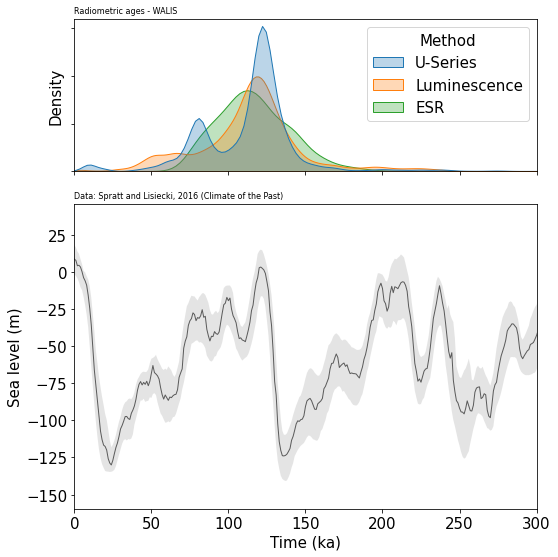

In [21]:
%run -i scripts/age_kde.py

# Create ZIP archive
Create a ZIP archive of the entire "Output" folder.

In [22]:
shutil.make_archive('Output', 'zip', Output_path)

'/Users/alessiorovere/Dropbox/Mac/Documents/GitHub/WALIS/WALIS/Output.zip'

# Suggested acknowledgments
WALIS is the result of the work of several people, within different projects. For this reason, we kindly ask you to follow these simple rules to properly acknowledge those who worked on it:

1. Cite the original authors - Please maintain the original citations for each datapoint, to give proper credit to those who worked to collect the original data in the field or in the lab.
2. Acknowledge the database contributor - The name of each contributor is listed in all public datapoints. This is the data creator, who spent time to make sure the data is standardized and (as much as possible) free of errors.
3. Acknowledge the database structure and interface creators - The database template used in this study was developed by the ERC Starting Grant "WARMCOASTS" (ERC-StG-802414) and is a community effort under the PALSEA (PAGES / INQUA) working group.

Example of acknowledgments: The data used in this study were *[extracted from / compiled in]* WALIS, a sea-level database interface developed by the ERC Starting Grant "WARMCOASTS" (ERC-StG-802414), in collaboration with PALSEA (PAGES / INQUA) working group. The database structure was designed by A. Rovere, D. Ryan, T. Lorscheid, A. Dutton, P. Chutcharavan, D. Brill, N. Jankowski, D. Mueller, M. Bartz, E. Gowan and K. Cohen. The data points used in this study were contributed to WALIS by *[list names of contributors here]*.